# Cleaning ETH and RTH Market Data
We combine extended trading hours (ETH) and regular trading hours (RTH) datasets into tidy
assets and option dataframes ready for downstream analysis.

## Dataset Overview
- **RTH vs ETH**: RTH covers the standard 09:30–16:00 ET NYSE session while ETH captures overnight and
  pre/post-market activity. Comparing both windows is vital because volatility shocks can start or fade outside
  cash hours, yet still influence pricing when the market reopens.
- **SPX**: The S&P 500 index represents the underlying spot level for every SPX option we analyze; tracking it
  alongside option quotes lets us compute moneyness, spot returns, and link surface shifts to index swings.
- **VIX**: The CBOE Volatility Index summarizes the 30-day implied variance from listed options, so monitoring
  it provides a benchmark for whether our bespoke volatility surfaces are consistent with market sentiment.
- **ES futures**: Front-month E-mini S&P 500 futures trade nearly 24 hours, offering a tradable proxy for SPX
  during ETH. Their bid/ask levels reveal how much of a move occurs before the cash market opens and aid in
  aligning option timestamps with corresponding underlying prices.
- **SPX options**: These listed index options across strikes/expiries supply the bid/ask quotes feeding our
  implied-volatility surface, risk-neutral PDF extraction, and hedging analysis; clean quotes are essential for
  reliable Greeks and surface diagnostics.

## Imports and Paths

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.width = 140
pd.options.display.max_columns = 20

PROJECT_ROOT = Path(".")
SESSION_FOLDERS = {"ETH": PROJECT_ROOT / "ETH", "RTH": PROJECT_ROOT / "RTH"}

## Helper Functions

In [2]:
# Helper routines: parsing CSVs, melting option quotes, and orchestrating session-level loads.
def parse_timestamped_csv(csv_path: Path) -> pd.DataFrame:
    """Load a CSV whose first column stores timestamps and return a tidy timestamp column."""
    frame = pd.read_csv(csv_path, index_col=0)
    frame.index = pd.to_datetime(frame.index)
    frame = frame.reset_index().rename(columns={"index": "timestamp"})
    return frame


def melt_option_quotes(frame: pd.DataFrame, value_name: str) -> pd.DataFrame:
    """Convert wide strike columns into long format for a single quote side."""
    melted = frame.melt(id_vars="timestamp", var_name="strike", value_name=value_name)
    melted["strike"] = pd.to_numeric(melted["strike"], errors="coerce")
    melted[value_name] = pd.to_numeric(melted[value_name], errors="coerce")
    return melted


def load_option_book(option_type: str) -> pd.DataFrame:
    """Load and merge bid/ask quotes for the requested option type across sessions."""
    records: list[pd.DataFrame] = []
    for session, folder in SESSION_FOLDERS.items():
        ask_files = sorted(folder.glob(f"*_{option_type}_ask_*.csv"))
        for ask_path in ask_files:
            stem_parts = ask_path.stem.split("_")
            quote_date = pd.to_datetime(stem_parts[0])
            expiry = pd.to_datetime(stem_parts[-1])
            bid_path = ask_path.with_name(ask_path.name.replace("_ask_", "_bid_"))
            if not bid_path.exists():
                continue

            ask_frame = melt_option_quotes(parse_timestamped_csv(ask_path), "ask")
            bid_frame = melt_option_quotes(parse_timestamped_csv(bid_path), "bid")
            merged = pd.merge(
                ask_frame, bid_frame, on=["timestamp", "strike"], how="outer"
            )

            merged["expiry"] = expiry
            merged["session"] = session
            merged["mid"] = merged[["bid", "ask"]].mean(axis=1)
            # merged = merged.dropna(subset=["strike"])
            # merged = merged.dropna(subset=["bid", "ask"], how="all")

            records.append(merged)

    long_df = pd.concat(records, ignore_index=True)
    long_df = long_df.sort_values(["timestamp", "strike"]).reset_index(drop=True)
    return long_df


def load_assets() -> pd.DataFrame:
    """Load SPX/ES/VIX snapshots from both sessions."""
    frames: list[pd.DataFrame] = []
    for session, folder in SESSION_FOLDERS.items():
        for csv_path in sorted(folder.glob("*_assets.csv")):
            frame = parse_timestamped_csv(csv_path)
            frame["session"] = session
            frames.append(frame)

    assets = pd.concat(frames, ignore_index=True)
    assets = assets.astype(
        {
            "SPX": "Float64",
            "ES_BID": "Float64",
            "ES_ASK": "Float64",
            "VIX": "Float64",
            "session": "category",
        }
    )
    assets = assets.sort_values("timestamp").reset_index(drop=True)
    return assets

## Visualization Utilities

In [3]:
# Provide reusable plotting helpers for exploratory analysis.
SESSION_COLORS = {"RTH": "#2ca02c", "ETH": "#1f77b4"}


def _shade_session_blocks(ax, series: pd.DataFrame) -> None:
    """Overlay lightly shaded regions for ETH and RTH stretches."""
    legend_labels = set()
    session_switch = series["session"].ne(series["session"].shift()).cumsum()
    for _, block in series.groupby(session_switch):
        session_name = block["session"].iloc[0]
        color = SESSION_COLORS.get(session_name, "gray")
        ax.axvspan(
            block["timestamp"].iloc[0],
            block["timestamp"].iloc[-1],
            color=color,
            alpha=0.08,
            label=session_name if session_name not in legend_labels else None,
        )
        legend_labels.add(session_name)


def _shade_weekends(ax, series: pd.DataFrame) -> None:
    """Shade weekend periods to highlight market closures."""
    if series.empty:
        return
    start = series["timestamp"].min().normalize()
    end = series["timestamp"].max().normalize()
    dates = pd.date_range(start, end, freq="D")
    weekend_label_added = False
    for day in dates:
        if day.dayofweek == 5:  # Saturday marks the start of the weekend
            ax.axvspan(
                day,
                day + pd.Timedelta(days=2),
                color="gray",
                alpha=0.12,
                label="Weekend" if not weekend_label_added else None,
            )
            weekend_label_added = True


def plot_timeseries(
    data: pd.DataFrame,
    column: str,
    label: str,
    session: str | None = None,
    line_color: str = "black",
) -> None:
    """Display a single time series with ETH/RTH overlays and weekend cues."""
    subset = data.copy()
    if session is not None:
        subset = subset[subset["session"] == session]

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(
        subset["timestamp"],
        subset[column],
        color=line_color,
        linewidth=1.5,
        label=label,
    )

    _shade_session_blocks(ax, subset)
    _shade_weekends(ax, subset)

    ax.set_ylabel(label)
    ax.set_xlabel("Timestamp")
    ax.set_title(f"{label} Over Time" + (f" - {session}" if session else ""))
    ax.grid(True, linestyle="--", alpha=0.3)
    event_date = pd.Timestamp("2025-04-02")
    ax.axvline(
        event_date,
        color="red",
        linestyle=":",
        linewidth=2,
        label="Liberation Day Tariffs (2 Apr 2025)",
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="best")
    fig.autofmt_xdate()
    plt.tight_layout()

## Load Assets Across Sessions

In [4]:
# Load, clean, and combine SPX, ES, and VIX snapshots from ETH and RTH.
assets_df = load_assets()
assets_df.head()

/var/folders/p3/7gy013yx2hn3mns87ysh4z4w0000gn/T/ipykernel_40922/3265375810.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  assets = pd.concat(frames, ignore_index=True)


,timestamp,SPX,ES_BID,ES_ASK,VIX,session
0,2025-04-01 09:31:21.491248,5590.32,5631.75,5632.0,22.66,RTH
1,2025-04-01 09:31:24.535800,5590.7,5631.75,5632.0,22.66,RTH
2,2025-04-01 09:31:27.582698,5589.06,5629.5,5629.75,22.66,RTH
3,2025-04-01 09:31:30.632772,5588.66,5630.5,5630.75,22.66,RTH
4,2025-04-01 09:31:33.638817,5588.82,5629.75,5630.0,22.69,RTH


In [5]:
assets_df.dtypes

timestamp    datetime64[ns]
SPX                 Float64
ES_BID              Float64
ES_ASK              Float64
VIX                 Float64
session            category
dtype: object

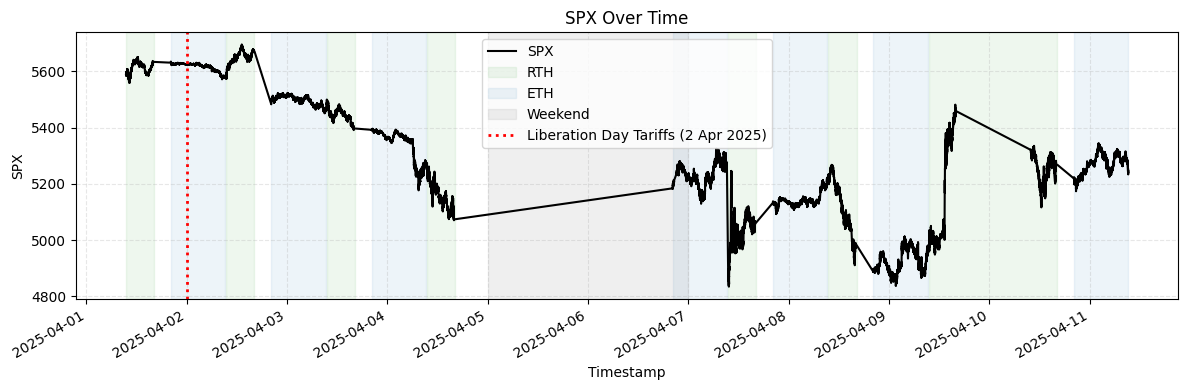

In [6]:
# Visualize SPX over time.
plot_timeseries(assets_df, column="SPX", label="SPX")

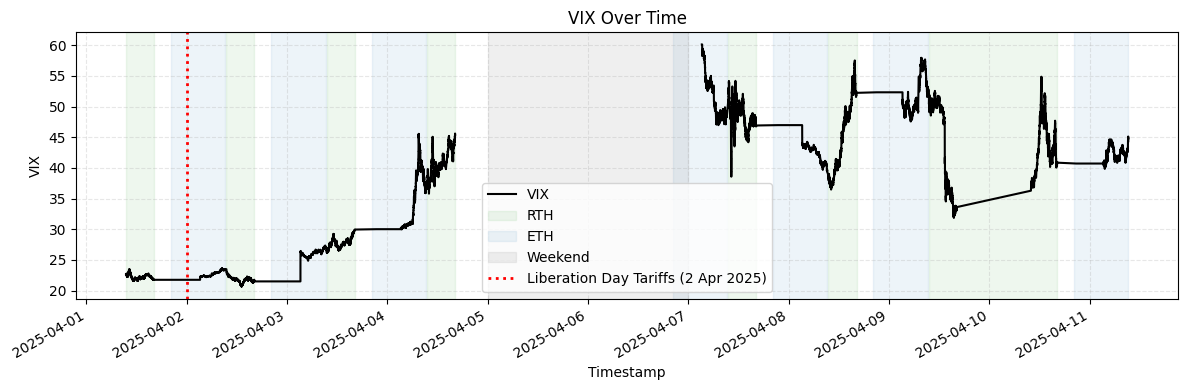

In [7]:
# Visualize VIX over time.
plot_timeseries(assets_df, column="VIX", label="VIX")

## Load Call Option Quotes

In [8]:
# Build the consolidated call option dataframe with bid/ask/mid quotes.
call_options_df = load_option_book("call")
call_options_df.head()

,timestamp,strike,ask,bid,expiry,session,mid
0,2025-04-01 09:31:21.491248,4600.0,1006.3,995.2,2025-04-16,RTH,1000.75
1,2025-04-01 09:31:21.491248,4625.0,981.5,971.7,2025-04-16,RTH,976.60
2,2025-04-01 09:31:21.491248,4650.0,956.7,945.7,2025-04-16,RTH,951.20
3,2025-04-01 09:31:21.491248,4675.0,932.0,921.4,2025-04-16,RTH,926.70
4,2025-04-01 09:31:21.491248,4700.0,907.2,896.6,2025-04-16,RTH,901.90


## Load Put Option Quotes

In [9]:
# Build the consolidated put option dataframe with bid/ask/mid quotes.
put_options_df = load_option_book("put")
put_options_df.head()

,timestamp,strike,ask,bid,expiry,session,mid
0,2025-04-01 09:31:21.491248,4600.0,3.5,3.2,2025-04-16,RTH,3.35
1,2025-04-01 09:31:21.491248,4625.0,3.6,3.3,2025-04-16,RTH,3.45
2,2025-04-01 09:31:21.491248,4650.0,3.8,3.5,2025-04-16,RTH,3.65
3,2025-04-01 09:31:21.491248,4675.0,4.0,3.6,2025-04-16,RTH,3.80
4,2025-04-01 09:31:21.491248,4700.0,4.1,3.8,2025-04-16,RTH,3.95
